# Step 1: Data Process


## Import dependencies

In [0]:
from google.colab import drive
drive.mount('/content/drive')
# here you will be given a URL and get a code to paste into a box below:

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
import random
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import gensim
import csv
import os
import pylab as plt
import math
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras
from collections import Counter

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


Using TensorFlow backend.


In [0]:
my_dir = "drive/My Drive/Colab Notebooks/"
os.chdir(my_dir)

In [0]:
!ls

backup			keras_baseline_4.ipynb	    processed_data2
data			keras_hierarchical_0.ipynb  __pycache__
keras_baseline_0.ipynb	keras_hierarchical_3.ipynb  sessions
keras_baseline_1.ipynb	keras_hierarchical.ipynb
keras_baseline_2.ipynb	processed_data


## Load in Data

In [0]:
# Process training data
filename = 'data/train.csv'

# # X: (REVIEW/TEXT), 
# # Y: (REVIEW/APPEARANCE, REVIEW/AROMA, REVIEW/PALATE, REVIEW/TASTE, REVIEW/OVERALL)
x_index = 11
y_index = [6, 7, 9, 10, 8] # reorder index to put overall as the last element
X = []
Y = []

with open(filename) as train:
    csv_reader = csv.reader(train, delimiter=',')
    i = -1
    for row in csv_reader:
      if i == -1:
        i += 1
        continue
      X.append(row[x_index])
      Y.append([row[j] for j in y_index])
      i += 1

print('data loading complete')

data loading complete


In [0]:
# Remove invalid inputs
X_valid = []
Y_valid = []
for i in range(len(X)):
  temp = list(map(float, Y[i]))
  if len(X[i]) != 0 and (0.5 not in temp) and (0.0 not in temp):
    X_valid.append(X[i].lower())
    Y_valid.append(temp)

assert len(X_valid) == len(Y_valid)

In [0]:
# Tokenize and make vocab
X_tokenized = list(map(lambda ele: word_tokenize(ele), X_valid))

In [0]:
print(len(X_tokenized))
print(len(Y_valid))

37489
37489


In [0]:
# Build vocab
vocabulary = set()
for parag in X_tokenized:
  vocabulary.update(set(parag))
vocabulary_dict = {word: (i+1) for i, word in enumerate(vocabulary)}

In [0]:
print(len(vocabulary))
print(len(vocabulary_dict))

61313
61313


In [0]:
from sklearn.model_selection import train_test_split
train_X, test_X, train_Y, test_Y = train_test_split(X_tokenized, Y_valid, test_size=0.2)

In [0]:
!nvidia-smi

Tue Jan 14 17:51:11 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.44       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Customized Dataset

In [0]:
class MyDataset(keras.utils.Sequence):
  'Characterizes a dataset for PyTorch'
  def __init__(self, documents, scores, word_to_idx, batch_size, hop_size=6):
        'Initialization'
        self.score_to_class_map = {
            1.0: 0,
            1.5: 1,
            2.0: 2,
            2.5: 3,
            3.0: 4,
            3.5: 5,
            4.0: 6,
            4.5: 7,
            5.0: 8
        }

        self.hop_size = hop_size
        self.word_to_idx = word_to_idx
        self.documents = documents
        self.batch_size = batch_size
        
        self.shuffle = True
        self.scores = None
        self.max_length = None
        self._initialize_process(documents, scores)

        # self.w2v = gensim.models.Word2Vec.load(root_dir + './w2v_model_128')
        self.sentence_dimension = int(self.max_length / self.hop_size) 
        self.on_epoch_end()

  def _initialize_process(self, documents, scores):
    assert len(scores) == len(documents)
    
    Y_array = np.asarray(scores, dtype=float)
    Y_mapped = self._prepare_score(Y_array)
    self.scores = Y_mapped

    max_parag_len = len(max(documents, key = lambda sentences : len(sentences)))
    self.max_length = math.ceil(max_parag_len / self.hop_size) * self.hop_size

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.documents))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __len__(self):
        'Denotes the total number of samples'
        return math.floor(len(self.scores) / self.batch_size)

  def __getitem__(self, input_index):
        'Generates one sample of data'
        # Select sample
        X = np.zeros((self.batch_size, self.max_length))
        Y = np.zeros((self.batch_size, 9))

        if (input_index+1)*self.batch_size < len(self.documents):
          indexes = self.indexes[input_index*self.batch_size : (input_index+1)*self.batch_size]
        else:
          indexes = self.indexes[input_index:self.batch_size, len(self.documents)-1] \
                + self.indexes[0, (input_index+1)*self.batch_size-len(self.documents)+1]
        for i in range(self.batch_size):
          index = indexes[i]
          doc = self.documents[index]   
          doc_in_idx = self._prepare_text(doc)    # max_len
          X[i] = doc_in_idx
          Y[i, int(self.scores[index][0])] = 1.0    # TODO: ASPECT CHANGE!!
          # classed_score = self._prepare_score(score)
        return X, Y

  def _prepare_score(self, scores):
      temp = np.zeros((scores.shape[0], scores.shape[1]))
      for i in range(scores.shape[0]):
        for j in range(scores.shape[1]):
          temp[i][j] = self.score_to_class_map[scores[i][j]]
      # print(temp)
      return temp

  def _prepare_text(self, parag):
    # parag_idx = []
    # for i, w in enumerate(parag):
    #   parag_idx.append(self.word_to_idx[w])
    X_idx = np.zeros(self.max_length)
    for i, w in enumerate(parag):
      # Pad at the head
      X_idx[self.max_length-len(parag)+i] = self.word_to_idx[w] 

    # X_sentenced = X_embeded.reshape((self.sentence_dimension, self.hop_size, self.embed_size))
    return X_idx


In [0]:
num_classes = 9
batch_size = 64

In [0]:
train_generator = MyDataset(train_X, train_Y, vocabulary_dict, batch_size)
test_x, test_y = train_generator.__getitem__(1)
print(test_x.shape, test_y.shape)

(64, 990) (64, 9)


In [0]:
# val_generator = MyDataset(train_X, train_Y, vocabulary_dict, batch_size)

In [0]:
test_generator = MyDataset(test_X, test_Y, vocabulary_dict, batch_size)

In [0]:
test_generator.scores[0]

array([7., 7., 6., 6., 6.])

# Step 2: Model Construction

In [0]:
import keras
from keras.models import Model
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, Activation, Masking, Bidirectional, Reshape, TimeDistributed
# from keras.layers import Add, Conv2D, MaxPooling1D, GlobalAveragePooling1D

In [0]:
lstm_hidden_size = 512
hop_size = 6
embed_size = 300

In [0]:
# LSTM Model
doc = Input(shape=(None,), name="input_doc")  # batch_size x max_length

# Embedding
embed_doc = Embedding(len(vocabulary)+1, embed_size, mask_zero=False, input_length=None)(doc) # batch_size x max_length x embed_size

# Reshape by hop_size
reshaped_embed_doc = Reshape((-1, hop_size, embed_size))(embed_doc) # batch_size x sents_length x hop_size x embed_size


# First LSTM 
hidden_seq1 = TimeDistributed(Bidirectional(LSTM(lstm_hidden_size, dropout=0.0, \
                                recurrent_dropout=0.0, return_sequences=False, \
                                return_state=False)))(reshaped_embed_doc) # batch_size x sents_length x (2 * hidden_size)

# Second LSTM
hidden_seq2 = Bidirectional(LSTM(lstm_hidden_size, dropout=0.0, \
                                recurrent_dropout=0.0, return_sequences=False, \
                                return_state=False))(hidden_seq1)     # batch_size x (2 * hidden_size)


# Linear Layers
dense = Dense(256, activation="relu")(hidden_seq2)
scores = Dense(num_classes, activation="softmax")(dense)
model = Model(inputs=doc, outputs=scores)

print(model.summary())




Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_doc (InputLayer)       (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 300)         18394200  
_________________________________________________________________
reshape_1 (Reshape)          (None, None, 6, 300)      0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 1024)        3330048   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 1024)              6295552   
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 2

In [0]:
# # CNN Model
# doc = Input(shape=(None,), name="input_doc")

# embed_doc = Embedding(len(vocabulary)+1, 300, mask_zero=False, input_length=None)(doc)

# conv1 = Conv1D(512, 5, strides=1, activation='relu')(embed_doc)
# conv2 = Conv1D(512, 5, strides=1, activation='relu')(conv1)
# max_pool1 = MaxPooling1D()(conv2)
# conv3 = Conv1D(512, 5, strides=1, activation='relu')(max_pool1)
# conv4 = Conv1D(512, 5, strides=1, activation='relu')(conv3)
# global_pool = GlobalAveragePooling1D()(conv4)

# dense = Dense(256, activation="relu")(global_pool)
# scores = Dense(num_classes, activation="softmax")(dense)

# model = Model(inputs=doc, outputs=scores)

# print(model.summary())

In [0]:
path = "./sessions/hierarchical_aspect0"    # TODO!!
checkpoints_path = os.path.join(path, 'checkpoints')
history_filename = 'history_' + path[path.rindex('/') + 1:] + '.csv'
early_stopping_patience = 10

if not os.path.exists("./sessions"):
    os.mkdir("./sessions")

if not os.path.exists(path):
    os.mkdir(path)

if not os.path.exists(checkpoints_path):
    os.mkdir(checkpoints_path)

In [0]:
# model.load_weights(os.path.join(checkpoints_path, "checkpoint.00009-1.413.hdf5"))

# Step 3: Review Embedding -> Aspect-level Sentiment Score

## Train

In [0]:
class ConfusionMatrixCallback(keras.callbacks.Callback):
  def _plot_confusion_matrix_helper(self, indices, y_expected):
    labels = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    cm = confusion_matrix(y_expected, indices, labels)
    print(cm)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticklabels([''] + labels)
    ax.set_yticklabels([''] + labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

  def _plot_confusion_matrix(self, y_output, y_expected):
    output_idx = np.argmax(y_output, axis=-1)
    print(output_idx)
    expected_idx = np.argmax(y_expected, axis=-1)
    assert output_idx.shape == expected_idx.shape  # batch * 5
    self._plot_confusion_matrix_helper(output_idx, expected_idx)

  def on_epoch_end(self, epoch, logs=None):
    x_train, y_train = test_generator.__getitem__(random.randint(0, test_generator.__len__()))
    y_predicted = model.predict(x_train)

    self._plot_confusion_matrix(y_predicted, y_train)



In [0]:
def get_callbacks():
    return [
        keras.callbacks.ReduceLROnPlateau(patience=early_stopping_patience / 2,
                                              cooldown=early_stopping_patience / 4,
                                              verbose=1),
        keras.callbacks.EarlyStopping(patience=early_stopping_patience, verbose=1,
                                          monitor='val_loss'),
        keras.callbacks.ModelCheckpoint(os.path.join(checkpoints_path, 'checkpoint.{epoch:05d}-{val_loss:.3f}.hdf5')),
        keras.callbacks.CSVLogger(os.path.join(path, history_filename), append=True),
        ConfusionMatrixCallback()
    ]

In [0]:
import tensorflow as tf
from keras.utils import to_categorical
def custom_loss(y_true, y_pred):
  return keras.losses.categorical_crossentropy(y_true, y_pred)

In [0]:
def calc_acc(y_expected, y_pred):
  return keras.metrics.categorical_accuracy(y_expected, y_pred)

In [0]:
from keras.optimizers import Adam
model.compile(optimizer=Adam(lr=0.00001), loss=custom_loss, metrics=[calc_acc])

In [0]:
!navidia_sim

/bin/bash: navidia_sim: command not found


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/100





100/100 [==============================] - 95s 951ms/step - loss: 2.0861 - calc_acc: 0.4153 - val_loss: 1.7804 - val_calc_acc: 0.4359
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0  2  0  0]]


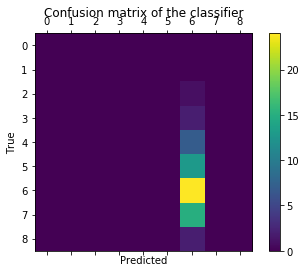

Epoch 2/100
100/100 [==============================] - 83s 831ms/step - loss: 1.5979 - calc_acc: 0.4350 - val_loss: 1.5208 - val_calc_acc: 0.4469
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0 26  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  2  0  0]]


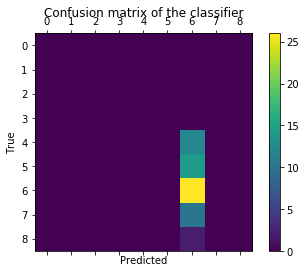

Epoch 3/100
100/100 [==============================] - 84s 841ms/step - loss: 1.5385 - calc_acc: 0.4245 - val_loss: 1.5666 - val_calc_acc: 0.4156
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0 28  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  2  0  0]]


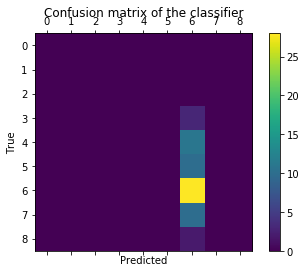

Epoch 4/100
100/100 [==============================] - 84s 839ms/step - loss: 1.5244 - calc_acc: 0.4223 - val_loss: 1.4796 - val_calc_acc: 0.4422
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0 30  0  0]
 [ 0  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0  1  0  0]]


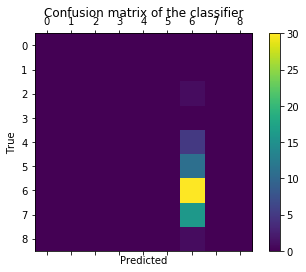

Epoch 5/100
100/100 [==============================] - 84s 844ms/step - loss: 1.5237 - calc_acc: 0.4283 - val_loss: 1.5046 - val_calc_acc: 0.4375
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0 17  0  0]
 [ 0  0  0  0  0  0  2  0  0]]


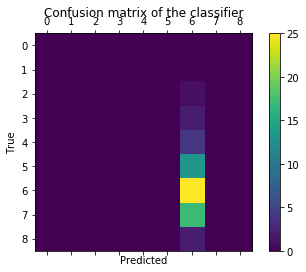

Epoch 6/100
100/100 [==============================] - 84s 840ms/step - loss: 1.5309 - calc_acc: 0.4267 - val_loss: 1.4950 - val_calc_acc: 0.4172
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 32  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  6  0  0]]


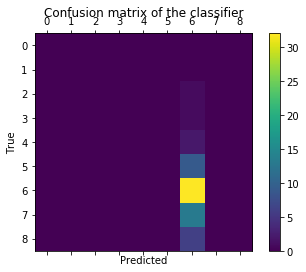

Epoch 7/100
100/100 [==============================] - 84s 843ms/step - loss: 1.5154 - calc_acc: 0.4306 - val_loss: 1.5011 - val_calc_acc: 0.4359
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0 27  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0  4  0  0]]


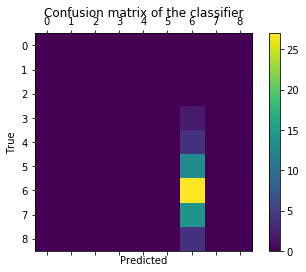

Epoch 8/100
100/100 [==============================] - 84s 841ms/step - loss: 1.5304 - calc_acc: 0.4245 - val_loss: 1.5121 - val_calc_acc: 0.4250
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  5  0  0]]


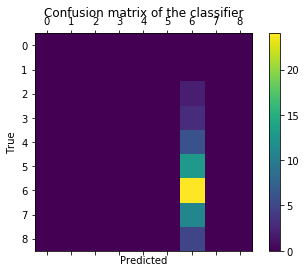

Epoch 9/100
100/100 [==============================] - 85s 849ms/step - loss: 1.5200 - calc_acc: 0.4186 - val_loss: 1.5422 - val_calc_acc: 0.4016

Epoch 00009: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0  8  0  0]
 [ 0  0  0  0  0  0 28  0  0]
 [ 0  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0  5  0  0]]


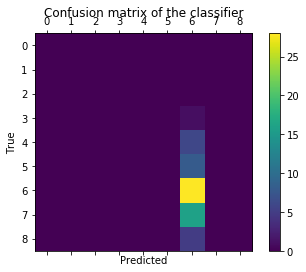

Epoch 10/100
100/100 [==============================] - 84s 842ms/step - loss: 1.4953 - calc_acc: 0.4377 - val_loss: 1.4450 - val_calc_acc: 0.4594
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 32  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  6  0  0]]


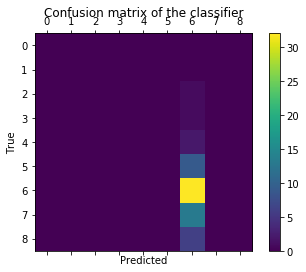

Epoch 11/100
100/100 [==============================] - 84s 842ms/step - loss: 1.4986 - calc_acc: 0.4355 - val_loss: 1.5206 - val_calc_acc: 0.4250
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0 17  0  0]
 [ 0  0  0  0  0  0 19  0  0]
 [ 0  0  0  0  0  0 18  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


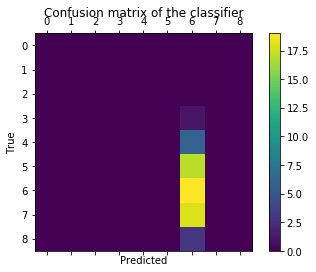

Epoch 12/100
100/100 [==============================] - 84s 841ms/step - loss: 1.5136 - calc_acc: 0.4298 - val_loss: 1.4976 - val_calc_acc: 0.4203
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0  4  0  0]]


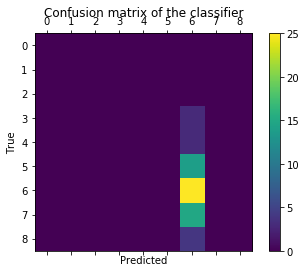

Epoch 13/100
100/100 [==============================] - 85s 848ms/step - loss: 1.5297 - calc_acc: 0.4214 - val_loss: 1.4791 - val_calc_acc: 0.4469
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 22  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  6  0  0]]


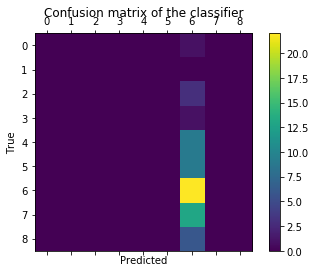

Epoch 14/100
100/100 [==============================] - 84s 837ms/step - loss: 1.5307 - calc_acc: 0.4239 - val_loss: 1.4700 - val_calc_acc: 0.4469
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0 29  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0  4  0  0]]


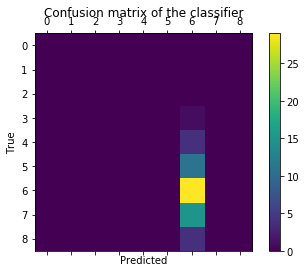

Epoch 15/100
100/100 [==============================] - 84s 837ms/step - loss: 1.5189 - calc_acc: 0.4277 - val_loss: 1.5203 - val_calc_acc: 0.4313
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0 29  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


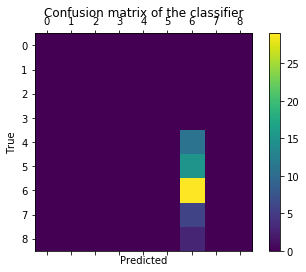

Epoch 16/100
100/100 [==============================] - 84s 844ms/step - loss: 1.5092 - calc_acc: 0.4270 - val_loss: 1.4399 - val_calc_acc: 0.4375
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0 35  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0  2  0  0]]


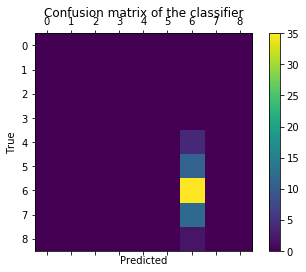

Epoch 17/100
100/100 [==============================] - 85s 845ms/step - loss: 1.5236 - calc_acc: 0.4231 - val_loss: 1.5044 - val_calc_acc: 0.4172
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0 31  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  2  0  0]]


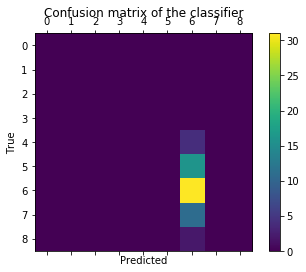

Epoch 18/100
100/100 [==============================] - 86s 857ms/step - loss: 1.5212 - calc_acc: 0.4277 - val_loss: 1.5716 - val_calc_acc: 0.3984
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0 29  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


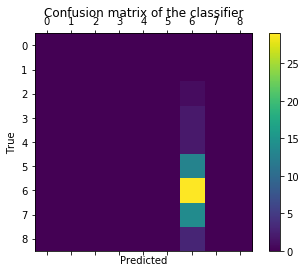

Epoch 19/100
100/100 [==============================] - 85s 851ms/step - loss: 1.4901 - calc_acc: 0.4348 - val_loss: 1.4937 - val_calc_acc: 0.4219
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0 29  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


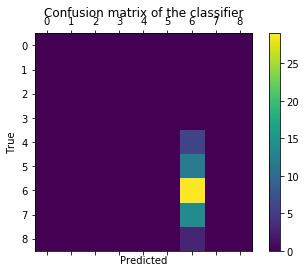

Epoch 20/100
100/100 [==============================] - 84s 842ms/step - loss: 1.5224 - calc_acc: 0.4261 - val_loss: 1.5582 - val_calc_acc: 0.4125
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0 31  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0  2  0  0]]


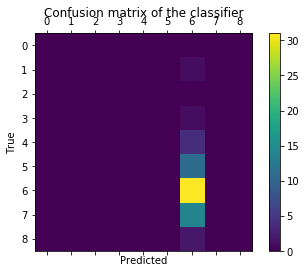

Epoch 21/100
100/100 [==============================] - 84s 844ms/step - loss: 1.5076 - calc_acc: 0.4339 - val_loss: 1.4936 - val_calc_acc: 0.4406

Epoch 00021: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  8  0  0]
 [ 0  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


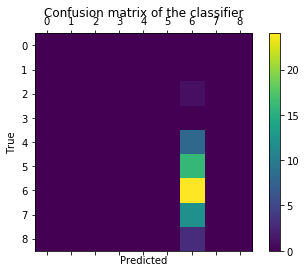

Epoch 22/100
100/100 [==============================] - 85s 846ms/step - loss: 1.5203 - calc_acc: 0.4227 - val_loss: 1.4787 - val_calc_acc: 0.4453
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0 30  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


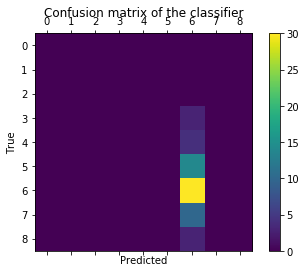

Epoch 23/100
100/100 [==============================] - 85s 847ms/step - loss: 1.5144 - calc_acc: 0.4255 - val_loss: 1.5045 - val_calc_acc: 0.4297
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 22  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  6  0  0]]


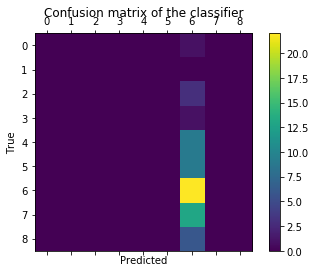

Epoch 24/100
100/100 [==============================] - 86s 856ms/step - loss: 1.5172 - calc_acc: 0.4309 - val_loss: 1.4533 - val_calc_acc: 0.4578
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0 19  0  0]
 [ 0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  2  0  0]]


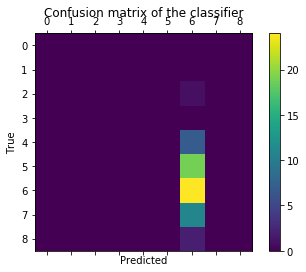

Epoch 25/100
100/100 [==============================] - 84s 838ms/step - loss: 1.4888 - calc_acc: 0.4366 - val_loss: 1.4632 - val_calc_acc: 0.4391
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0 29  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0  2  0  0]]


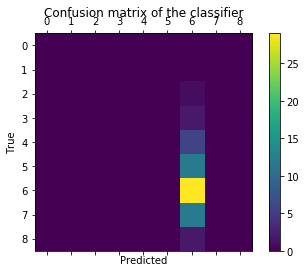

Epoch 26/100
100/100 [==============================] - 84s 837ms/step - loss: 1.5191 - calc_acc: 0.4255 - val_loss: 1.5325 - val_calc_acc: 0.4062
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 29  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  5  0  0]]


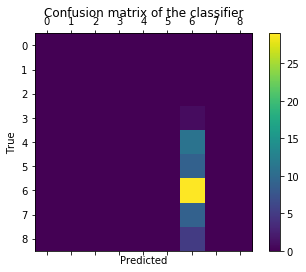

Epoch 27/100
100/100 [==============================] - 83s 834ms/step - loss: 1.5202 - calc_acc: 0.4278 - val_loss: 1.5166 - val_calc_acc: 0.4437
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0 32  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  6  0  0]]


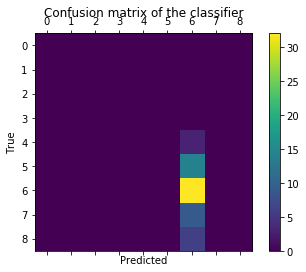

Epoch 28/100
100/100 [==============================] - 84s 841ms/step - loss: 1.5280 - calc_acc: 0.4200 - val_loss: 1.4826 - val_calc_acc: 0.4328

Epoch 00028: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0 22  0  0]
 [ 0  0  0  0  0  0 18  0  0]
 [ 0  0  0  0  0  0  4  0  0]]


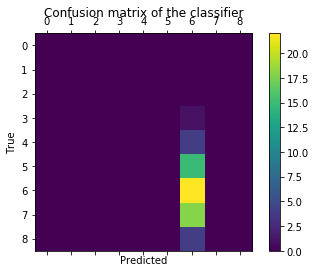

Epoch 29/100
100/100 [==============================] - 83s 833ms/step - loss: 1.5119 - calc_acc: 0.4239 - val_loss: 1.5101 - val_calc_acc: 0.4188
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0 21  0  0]
 [ 0  0  0  0  0  0  5  0  0]]


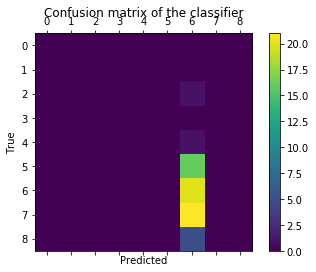

Epoch 30/100
100/100 [==============================] - 84s 835ms/step - loss: 1.4968 - calc_acc: 0.4347 - val_loss: 1.5471 - val_calc_acc: 0.3859
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0 18  0  0]
 [ 0  0  0  0  0  0  1  0  0]]


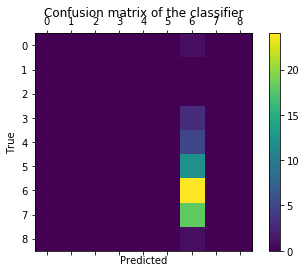

Epoch 31/100
100/100 [==============================] - 83s 832ms/step - loss: 1.5099 - calc_acc: 0.4284 - val_loss: 1.5086 - val_calc_acc: 0.4297
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0 27  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0  5  0  0]]


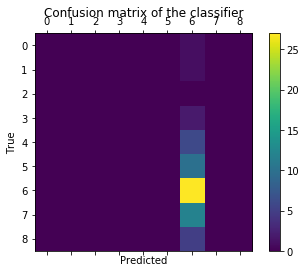

Epoch 32/100
100/100 [==============================] - 83s 827ms/step - loss: 1.5287 - calc_acc: 0.4191 - val_loss: 1.5376 - val_calc_acc: 0.4156
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  8  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  5  0  0]]


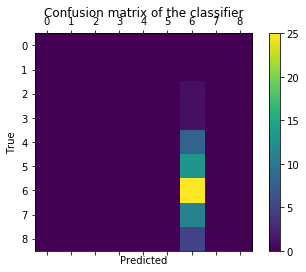

Epoch 33/100
100/100 [==============================] - 84s 835ms/step - loss: 1.5150 - calc_acc: 0.4363 - val_loss: 1.4194 - val_calc_acc: 0.4734
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0 29  0  0]
 [ 0  0  0  0  0  0  8  0  0]
 [ 0  0  0  0  0  0  4  0  0]]


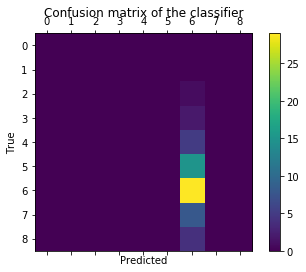

Epoch 34/100
100/100 [==============================] - 83s 834ms/step - loss: 1.5066 - calc_acc: 0.4263 - val_loss: 1.4824 - val_calc_acc: 0.4453
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0 18  0  0]
 [ 0  0  0  0  0  0 23  0  0]
 [ 0  0  0  0  0  0  9  0  0]]


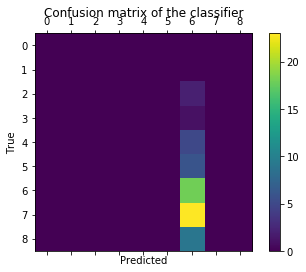

Epoch 35/100
100/100 [==============================] - 84s 841ms/step - loss: 1.5084 - calc_acc: 0.4308 - val_loss: 1.5254 - val_calc_acc: 0.4203
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0 32  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  1  0  0]]


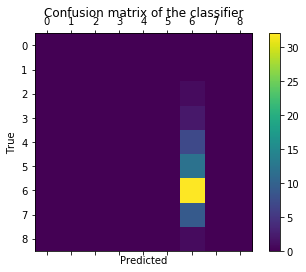

Epoch 36/100
100/100 [==============================] - 84s 838ms/step - loss: 1.5208 - calc_acc: 0.4233 - val_loss: 1.4781 - val_calc_acc: 0.4359
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0 17  0  0]
 [ 0  0  0  0  0  0 27  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


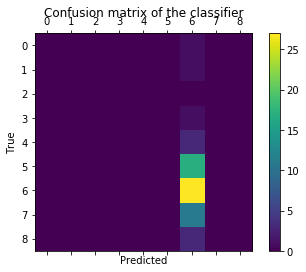

Epoch 37/100
100/100 [==============================] - 84s 836ms/step - loss: 1.5030 - calc_acc: 0.4320 - val_loss: 1.4842 - val_calc_acc: 0.4391
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0 30  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


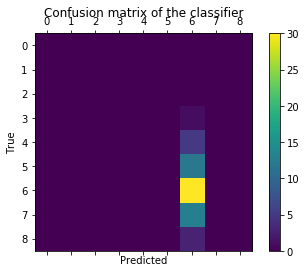

Epoch 38/100
100/100 [==============================] - 84s 836ms/step - loss: 1.5326 - calc_acc: 0.4169 - val_loss: 1.4588 - val_calc_acc: 0.4422

Epoch 00038: ReduceLROnPlateau reducing learning rate to 9.999999939225292e-10.
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0 28  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0  1  0  0]]


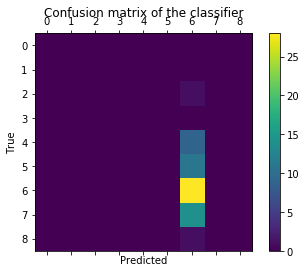

Epoch 39/100
100/100 [==============================] - 83s 830ms/step - loss: 1.5242 - calc_acc: 0.4275 - val_loss: 1.4421 - val_calc_acc: 0.4437
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0  1  0  0]]


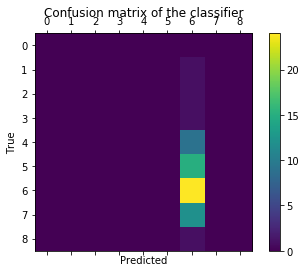

Epoch 40/100
100/100 [==============================] - 83s 835ms/step - loss: 1.5003 - calc_acc: 0.4356 - val_loss: 1.4701 - val_calc_acc: 0.4594
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0 22  0  0]
 [ 0  0  0  0  0  0 19  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


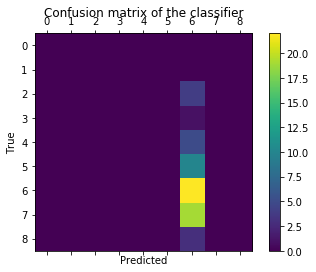

Epoch 41/100
100/100 [==============================] - 83s 834ms/step - loss: 1.5184 - calc_acc: 0.4198 - val_loss: 1.5230 - val_calc_acc: 0.4062
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0 37  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  1  0  0]]


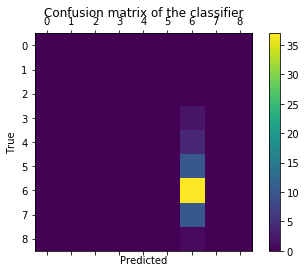

Epoch 42/100
100/100 [==============================] - 84s 835ms/step - loss: 1.5036 - calc_acc: 0.4373 - val_loss: 1.5751 - val_calc_acc: 0.3953
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0 30  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  4  0  0]]


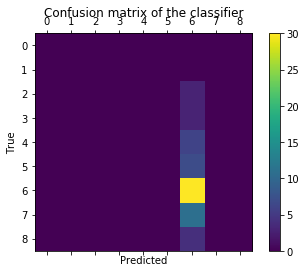

Epoch 43/100
100/100 [==============================] - 84s 840ms/step - loss: 1.5113 - calc_acc: 0.4386 - val_loss: 1.5006 - val_calc_acc: 0.4266
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0 31  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  7  0  0]]


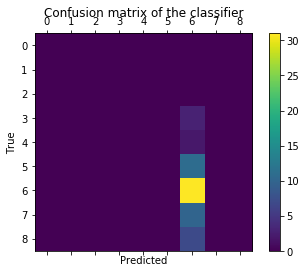

Epoch 44/100
100/100 [==============================] - 83s 830ms/step - loss: 1.5173 - calc_acc: 0.4191 - val_loss: 1.5168 - val_calc_acc: 0.4406
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0 29  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0  6  0  0]]


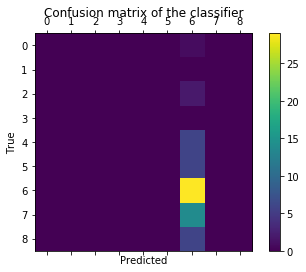

Epoch 45/100
100/100 [==============================] - 83s 832ms/step - loss: 1.5184 - calc_acc: 0.4258 - val_loss: 1.4857 - val_calc_acc: 0.4141

Epoch 00045: ReduceLROnPlateau reducing learning rate to 9.999999717180686e-11.
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0 26  0  0]
 [ 0  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0  6  0  0]]


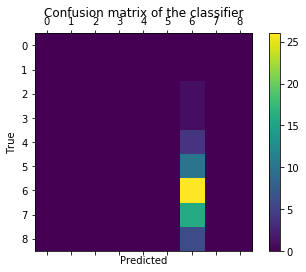

Epoch 46/100
100/100 [==============================] - 84s 838ms/step - loss: 1.5160 - calc_acc: 0.4247 - val_loss: 1.5045 - val_calc_acc: 0.4422
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0 36  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  1  0  0]]


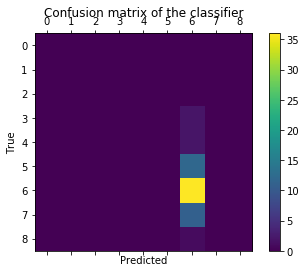

Epoch 47/100
100/100 [==============================] - 84s 839ms/step - loss: 1.5077 - calc_acc: 0.4280 - val_loss: 1.5018 - val_calc_acc: 0.4437
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0 29  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  2  0  0]]


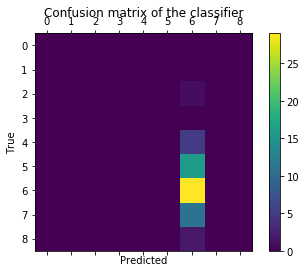

Epoch 48/100
100/100 [==============================] - 83s 830ms/step - loss: 1.5221 - calc_acc: 0.4261 - val_loss: 1.4805 - val_calc_acc: 0.4328
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0 30  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


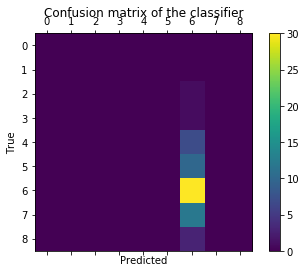

Epoch 49/100
100/100 [==============================] - 84s 838ms/step - loss: 1.5137 - calc_acc: 0.4294 - val_loss: 1.5024 - val_calc_acc: 0.4437
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0  6  0  0]]


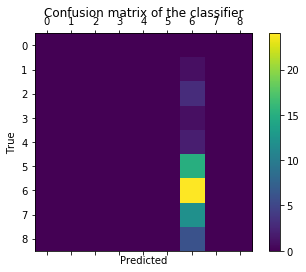

Epoch 50/100
100/100 [==============================] - 83s 834ms/step - loss: 1.5070 - calc_acc: 0.4261 - val_loss: 1.5541 - val_calc_acc: 0.4156
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0 32  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


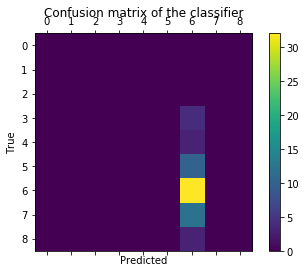

Epoch 51/100
100/100 [==============================] - 83s 832ms/step - loss: 1.5175 - calc_acc: 0.4261 - val_loss: 1.4762 - val_calc_acc: 0.4109
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0 32  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


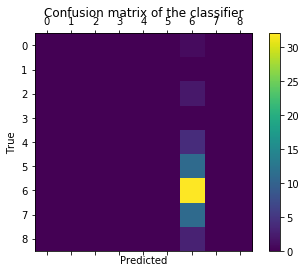

Epoch 52/100
100/100 [==============================] - 83s 832ms/step - loss: 1.5109 - calc_acc: 0.4331 - val_loss: 1.4870 - val_calc_acc: 0.4313

Epoch 00052: ReduceLROnPlateau reducing learning rate to 9.99999943962493e-12.
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0 20  0  0]
 [ 0  0  0  0  0  0 22  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0  4  0  0]]


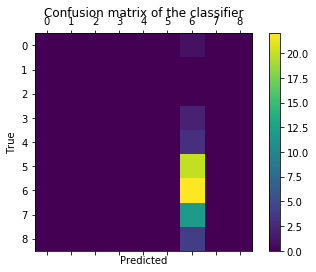

Epoch 53/100
100/100 [==============================] - 84s 840ms/step - loss: 1.5168 - calc_acc: 0.4250 - val_loss: 1.4599 - val_calc_acc: 0.4391
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  8  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0 32  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  0  0  0]]


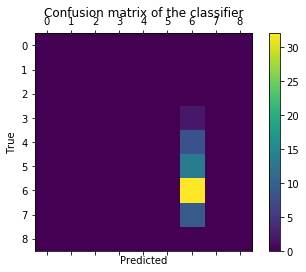

Epoch 54/100
100/100 [==============================] - 83s 829ms/step - loss: 1.5137 - calc_acc: 0.4300 - val_loss: 1.5299 - val_calc_acc: 0.4031
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0 29  0  0]
 [ 0  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0  0  0  0]]


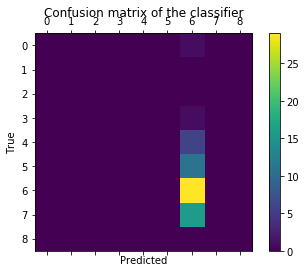

Epoch 55/100
100/100 [==============================] - 83s 827ms/step - loss: 1.5073 - calc_acc: 0.4308 - val_loss: 1.4908 - val_calc_acc: 0.4266
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0 31  0  0]
 [ 0  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


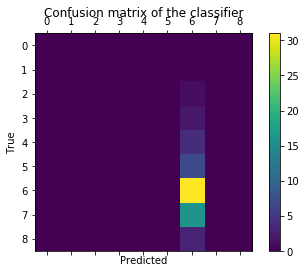

Epoch 56/100
100/100 [==============================] - 83s 825ms/step - loss: 1.5165 - calc_acc: 0.4247 - val_loss: 1.4871 - val_calc_acc: 0.4453
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0 30  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0  1  0  0]]


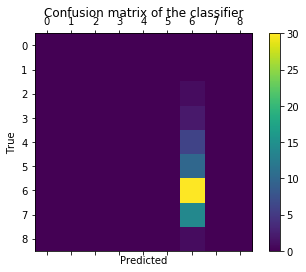

Epoch 57/100
100/100 [==============================] - 83s 834ms/step - loss: 1.5159 - calc_acc: 0.4261 - val_loss: 1.5162 - val_calc_acc: 0.4453
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0 28  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0  2  0  0]]


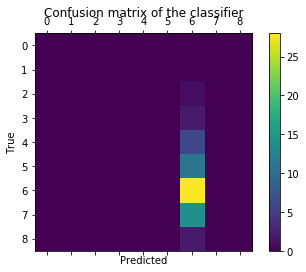

Epoch 58/100
100/100 [==============================] - 84s 839ms/step - loss: 1.5172 - calc_acc: 0.4305 - val_loss: 1.4991 - val_calc_acc: 0.4453
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0 28  0  0]
 [ 0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  2  0  0]]


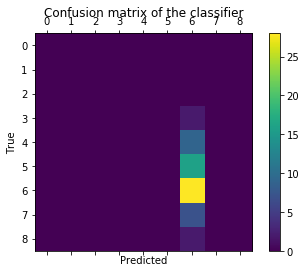

Epoch 59/100
100/100 [==============================] - 83s 835ms/step - loss: 1.5016 - calc_acc: 0.4297 - val_loss: 1.5139 - val_calc_acc: 0.4062

Epoch 00059: ReduceLROnPlateau reducing learning rate to 9.999999092680235e-13.
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  6  0  0]]


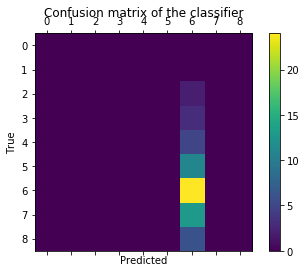

Epoch 60/100
100/100 [==============================] - 83s 830ms/step - loss: 1.5251 - calc_acc: 0.4225 - val_loss: 1.4891 - val_calc_acc: 0.4547
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0 26  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  6  0  0]]


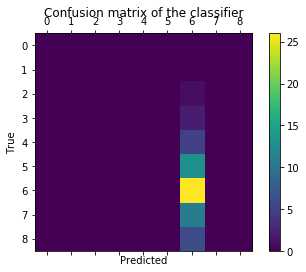

Epoch 61/100
100/100 [==============================] - 84s 838ms/step - loss: 1.5057 - calc_acc: 0.4295 - val_loss: 1.5540 - val_calc_acc: 0.3906
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0 38  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0  0  0  0]]


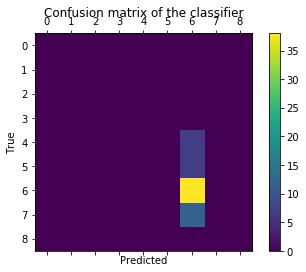

Epoch 62/100
100/100 [==============================] - 83s 830ms/step - loss: 1.5180 - calc_acc: 0.4245 - val_loss: 1.5106 - val_calc_acc: 0.4375
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 27  0  0]
 [ 0  0  0  0  0  0 17  0  0]
 [ 0  0  0  0  0  0  4  0  0]]


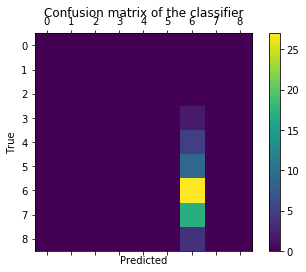

Epoch 63/100
100/100 [==============================] - 83s 834ms/step - loss: 1.5200 - calc_acc: 0.4209 - val_loss: 1.5112 - val_calc_acc: 0.4125
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 28  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0  7  0  0]]


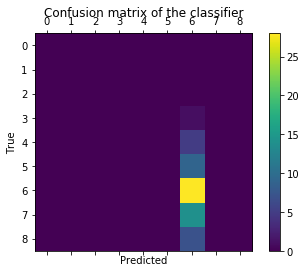

Epoch 64/100
100/100 [==============================] - 82s 823ms/step - loss: 1.5183 - calc_acc: 0.4305 - val_loss: 1.5366 - val_calc_acc: 0.4219
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0 26  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  5  0  0]]


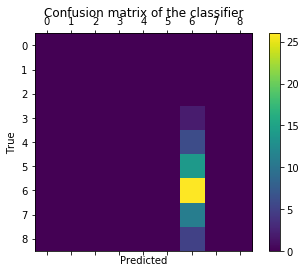

Epoch 65/100
100/100 [==============================] - 83s 826ms/step - loss: 1.4985 - calc_acc: 0.4375 - val_loss: 1.4484 - val_calc_acc: 0.4594
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0  5  0  0]]


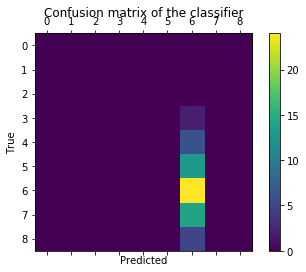

Epoch 66/100
100/100 [==============================] - 83s 834ms/step - loss: 1.5212 - calc_acc: 0.4242 - val_loss: 1.4598 - val_calc_acc: 0.4484

Epoch 00066: ReduceLROnPlateau reducing learning rate to 9.9999988758398e-14.
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0 30  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0  0  0  0]]


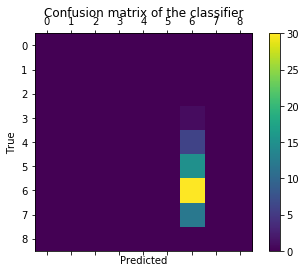

Epoch 67/100
100/100 [==============================] - 82s 823ms/step - loss: 1.5003 - calc_acc: 0.4350 - val_loss: 1.5170 - val_calc_acc: 0.4375
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 18  0  0]
 [ 0  0  0  0  0  0 22  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


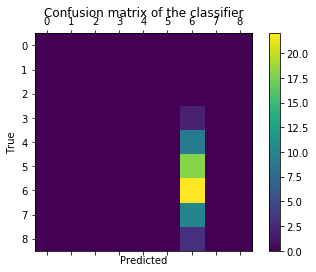

Epoch 68/100
100/100 [==============================] - 84s 836ms/step - loss: 1.5131 - calc_acc: 0.4302 - val_loss: 1.4959 - val_calc_acc: 0.3969
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0 21  0  0]
 [ 0  0  0  0  0  0 19  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  1  0  0]]


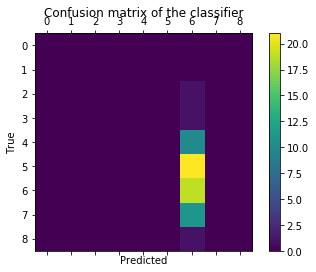

Epoch 69/100
100/100 [==============================] - 84s 835ms/step - loss: 1.5204 - calc_acc: 0.4283 - val_loss: 1.5293 - val_calc_acc: 0.4281
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  8  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0 27  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


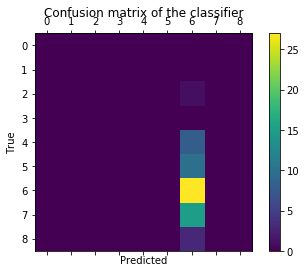

Epoch 70/100
100/100 [==============================] - 83s 832ms/step - loss: 1.5226 - calc_acc: 0.4167 - val_loss: 1.4390 - val_calc_acc: 0.4656
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 17  0  0]
 [ 0  0  0  0  0  0 21  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  2  0  0]]


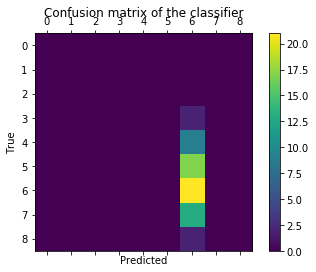

Epoch 71/100
100/100 [==============================] - 83s 828ms/step - loss: 1.5216 - calc_acc: 0.4356 - val_loss: 1.4428 - val_calc_acc: 0.4344
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 33  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  2  0  0]]


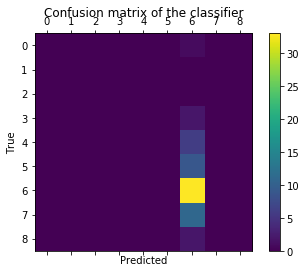

Epoch 72/100
100/100 [==============================] - 82s 824ms/step - loss: 1.4982 - calc_acc: 0.4323 - val_loss: 1.4704 - val_calc_acc: 0.4156
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0 27  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


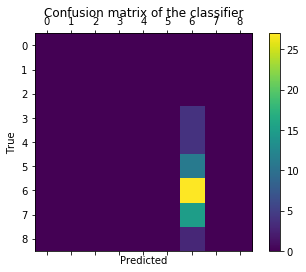

Epoch 73/100
100/100 [==============================] - 83s 832ms/step - loss: 1.5228 - calc_acc: 0.4220 - val_loss: 1.5064 - val_calc_acc: 0.4391

Epoch 00073: ReduceLROnPlateau reducing learning rate to 9.999999146890344e-15.
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


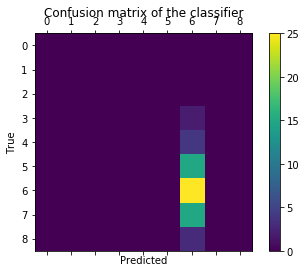

Epoch 74/100
100/100 [==============================] - 84s 842ms/step - loss: 1.5098 - calc_acc: 0.4248 - val_loss: 1.5057 - val_calc_acc: 0.4234
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0 26  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0  1  0  0]]


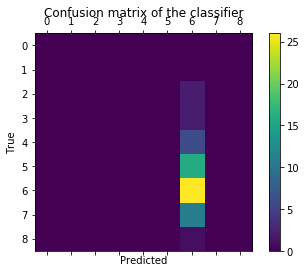

Epoch 75/100
100/100 [==============================] - 83s 833ms/step - loss: 1.5097 - calc_acc: 0.4275 - val_loss: 1.4804 - val_calc_acc: 0.4484
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0 30  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  5  0  0]]


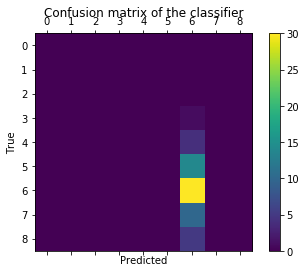

Epoch 76/100
100/100 [==============================] - 83s 826ms/step - loss: 1.5097 - calc_acc: 0.4236 - val_loss: 1.5316 - val_calc_acc: 0.4203
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 26  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  4  0  0]]


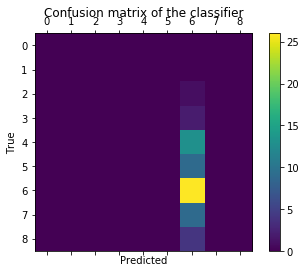

Epoch 77/100
100/100 [==============================] - 83s 829ms/step - loss: 1.5233 - calc_acc: 0.4259 - val_loss: 1.5018 - val_calc_acc: 0.4594
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0 28  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0  2  0  0]]


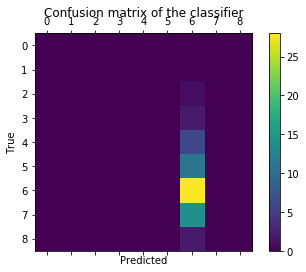

Epoch 78/100
100/100 [==============================] - 83s 828ms/step - loss: 1.5034 - calc_acc: 0.4347 - val_loss: 1.5056 - val_calc_acc: 0.4375
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 26  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  4  0  0]]


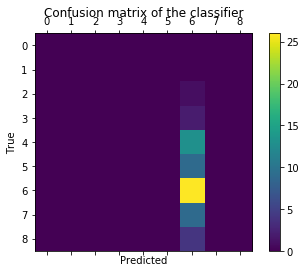

Epoch 79/100
100/100 [==============================] - 83s 831ms/step - loss: 1.5162 - calc_acc: 0.4291 - val_loss: 1.5010 - val_calc_acc: 0.4156
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 26  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0  4  0  0]]


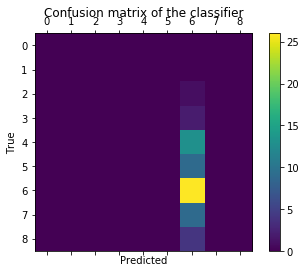

Epoch 80/100
100/100 [==============================] - 83s 831ms/step - loss: 1.5150 - calc_acc: 0.4200 - val_loss: 1.4989 - val_calc_acc: 0.4375

Epoch 00080: ReduceLROnPlateau reducing learning rate to 9.999998977483753e-16.
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0 28  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  4  0  0]]


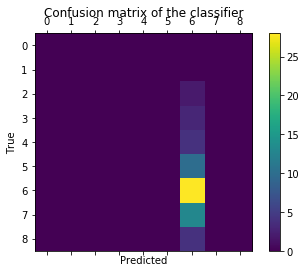

Epoch 81/100
100/100 [==============================] - 83s 830ms/step - loss: 1.5086 - calc_acc: 0.4253 - val_loss: 1.5362 - val_calc_acc: 0.4047
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0 30  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  1  0  0]]


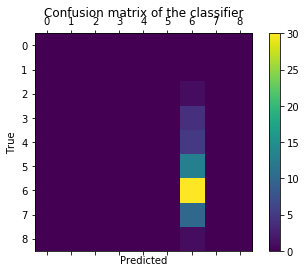

Epoch 82/100
100/100 [==============================] - 84s 839ms/step - loss: 1.5036 - calc_acc: 0.4372 - val_loss: 1.4672 - val_calc_acc: 0.4422
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0 30  0  0]
 [ 0  0  0  0  0  0  8  0  0]
 [ 0  0  0  0  0  0  2  0  0]]


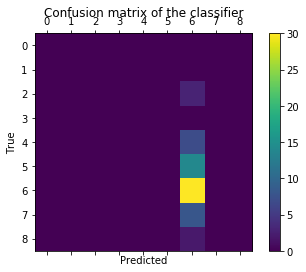

Epoch 83/100
100/100 [==============================] - 84s 838ms/step - loss: 1.5044 - calc_acc: 0.4363 - val_loss: 1.5037 - val_calc_acc: 0.4313
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0 17  0  0]
 [ 0  0  0  0  0  0 28  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0  5  0  0]]


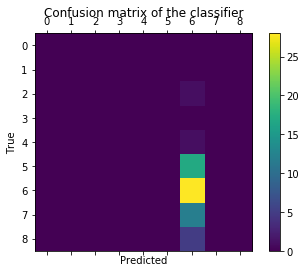

Epoch 84/100
100/100 [==============================] - 83s 830ms/step - loss: 1.5314 - calc_acc: 0.4214 - val_loss: 1.4749 - val_calc_acc: 0.4484
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0 18  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


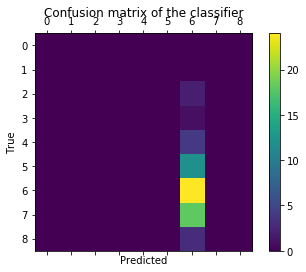

Epoch 85/100
100/100 [==============================] - 83s 834ms/step - loss: 1.5253 - calc_acc: 0.4269 - val_loss: 1.4904 - val_calc_acc: 0.4125
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  8  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  5  0  0]]


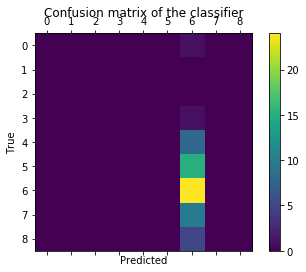

Epoch 86/100
100/100 [==============================] - 85s 854ms/step - loss: 1.4981 - calc_acc: 0.4259 - val_loss: 1.5214 - val_calc_acc: 0.4156
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0 22  0  0]
 [ 0  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0  4  0  0]]


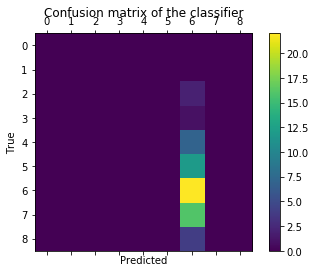

Epoch 87/100
100/100 [==============================] - 86s 857ms/step - loss: 1.5221 - calc_acc: 0.4252 - val_loss: 1.5010 - val_calc_acc: 0.4203

Epoch 00087: ReduceLROnPlateau reducing learning rate to 9.999998977483754e-17.
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  5  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0 28  0  0]
 [ 0  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0  4  0  0]]


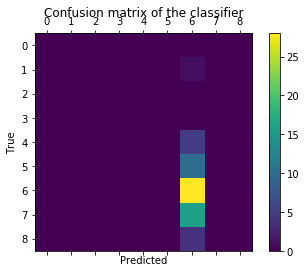

Epoch 88/100
100/100 [==============================] - 86s 855ms/step - loss: 1.5197 - calc_acc: 0.4284 - val_loss: 1.5173 - val_calc_acc: 0.4188
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0 26  0  0]
 [ 0  0  0  0  0  0 17  0  0]
 [ 0  0  0  0  0  0  1  0  0]]


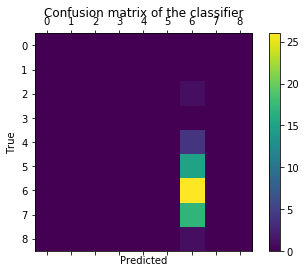

Epoch 89/100
100/100 [==============================] - 85s 851ms/step - loss: 1.5052 - calc_acc: 0.4319 - val_loss: 1.4697 - val_calc_acc: 0.4719
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0 23  0  0]
 [ 0  0  0  0  0  0 17  0  0]
 [ 0  0  0  0  0  0  8  0  0]]


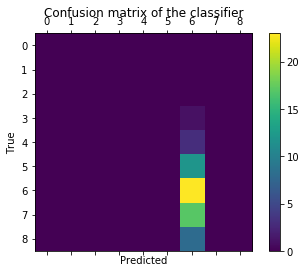

Epoch 90/100
100/100 [==============================] - 86s 855ms/step - loss: 1.5067 - calc_acc: 0.4327 - val_loss: 1.4771 - val_calc_acc: 0.4359
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0 29  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  2  0  0]]


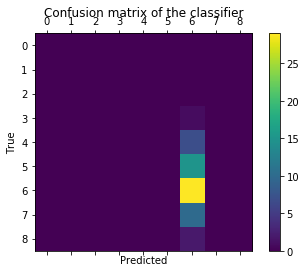

Epoch 91/100
100/100 [==============================] - 85s 852ms/step - loss: 1.5235 - calc_acc: 0.4233 - val_loss: 1.4838 - val_calc_acc: 0.4469
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0 33  0  0]
 [ 0  0  0  0  0  0 13  0  0]
 [ 0  0  0  0  0  0  2  0  0]]


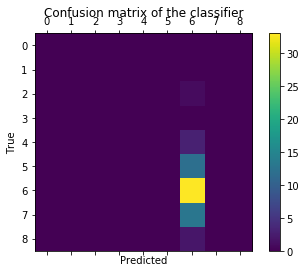

Epoch 92/100
100/100 [==============================] - 85s 854ms/step - loss: 1.5095 - calc_acc: 0.4278 - val_loss: 1.5093 - val_calc_acc: 0.4281
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0 23  0  0]
 [ 0  0  0  0  0  0 18  0  0]
 [ 0  0  0  0  0  0  2  0  0]]


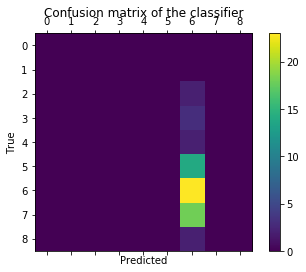

Epoch 93/100
100/100 [==============================] - 85s 855ms/step - loss: 1.5215 - calc_acc: 0.4247 - val_loss: 1.5308 - val_calc_acc: 0.4141
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0 28  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0  2  0  0]]


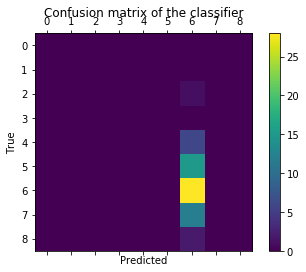

Epoch 94/100
100/100 [==============================] - 85s 849ms/step - loss: 1.5159 - calc_acc: 0.4277 - val_loss: 1.5274 - val_calc_acc: 0.4016

Epoch 00094: ReduceLROnPlateau reducing learning rate to 9.999998845134856e-18.
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0 32  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0  4  0  0]]


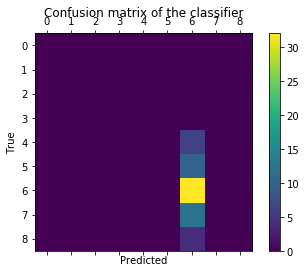

Epoch 95/100
100/100 [==============================] - 83s 832ms/step - loss: 1.5046 - calc_acc: 0.4344 - val_loss: 1.5527 - val_calc_acc: 0.4188
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  7  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0 25  0  0]
 [ 0  0  0  0  0  0 12  0  0]
 [ 0  0  0  0  0  0  3  0  0]]


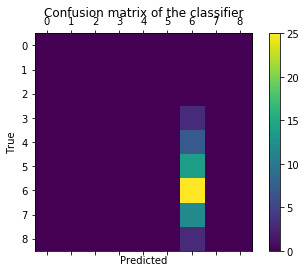

Epoch 96/100
100/100 [==============================] - 83s 833ms/step - loss: 1.5124 - calc_acc: 0.4247 - val_loss: 1.4694 - val_calc_acc: 0.4516
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 27  0  0]
 [ 0  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0  6  0  0]]


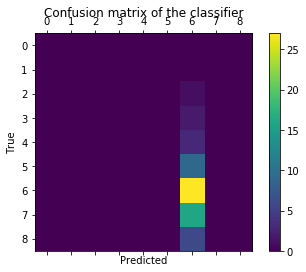

Epoch 97/100
100/100 [==============================] - 83s 827ms/step - loss: 1.5232 - calc_acc: 0.4192 - val_loss: 1.5107 - val_calc_acc: 0.4422
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0 15  0  0]
 [ 0  0  0  0  0  0  7  0  0]]


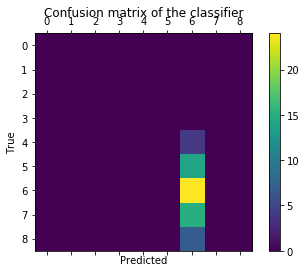

Epoch 98/100
100/100 [==============================] - 84s 839ms/step - loss: 1.5127 - calc_acc: 0.4288 - val_loss: 1.4756 - val_calc_acc: 0.4328
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0 24  0  0]
 [ 0  0  0  0  0  0 23  0  0]
 [ 0  0  0  0  0  0  0  0  0]]


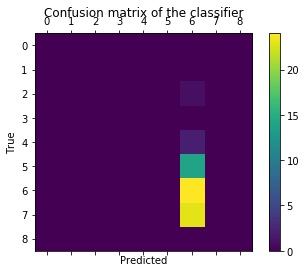

Epoch 99/100
100/100 [==============================] - 84s 835ms/step - loss: 1.5064 - calc_acc: 0.4347 - val_loss: 1.4743 - val_calc_acc: 0.4406
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0  0]
 [ 0  0  0  0  0  0  3  0  0]
 [ 0  0  0  0  0  0 16  0  0]
 [ 0  0  0  0  0  0 30  0  0]
 [ 0  0  0  0  0  0 14  0  0]
 [ 0  0  0  0  0  0  0  0  0]]


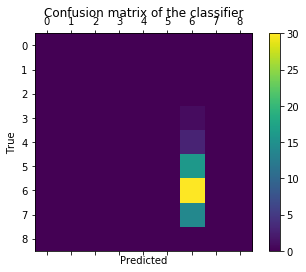

Epoch 100/100
100/100 [==============================] - 83s 832ms/step - loss: 1.5034 - calc_acc: 0.4325 - val_loss: 1.5124 - val_calc_acc: 0.4219
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6]
[[ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  4  0  0]
 [ 0  0  0  0  0  0  6  0  0]
 [ 0  0  0  0  0  0 11  0  0]
 [ 0  0  0  0  0  0 31  0  0]
 [ 0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  2  0  0]]


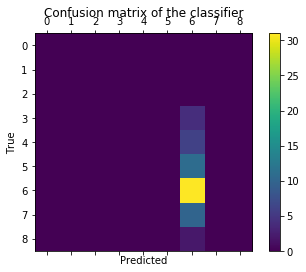

Epoch 00100: early stopping


In [32]:
model.fit_generator(train_generator, 
          epochs=100, 
          verbose=1, 
          callbacks=get_callbacks(), 
          validation_data=test_generator, 
          shuffle=True, 
          initial_epoch=0, 
          steps_per_epoch=100, 
          validation_steps=10)

## Test

In [0]:
path = "./sessions/hierarchical_aspect0"  #TODO!!
checkpoints_path = os.path.join(path, 'checkpoints')
history_filename = 'history_' + path[path.rindex('/') + 1:] + '.csv'
early_stopping_patience = 10

if not os.path.exists("./sessions"):
    os.mkdir("./sessions")

if not os.path.exists(path):
    os.mkdir(path)

if not os.path.exists(checkpoints_path):
    os.mkdir(checkpoints_path)

In [0]:
val_X = val_generator.data_generation(val_generator.list_IDs)

In [0]:
val_Pred = model.predict(val_X[0], batch_size=64)

In [0]:
pred_dict = []
for j, ID in enumerate(val_generator.list_IDs):
  pred_dict.append({"question_id": ID, "answer": answers_1000[np.argmax(val_Pred[j, :])][0]})
print(val_Pred.shape)

(214354, 1000)


In [0]:
import json
json.dump(pred_dict, open("./VQA/Results/baseline_results.json", "w"))